In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True) # Mounting google drive as the data and folder structure is stored in the drive

Mounted at /content/gdrive


In [ ]:
# importing required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Defining functions to calculate metrics complexity,p_entropy

In [ ]:

''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op): 
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

#### The code below reads the files from the folder and appends it to a dataframe, the columns Subject,Activity and Sensor Location are derived from the file names in the folder structure shown below 


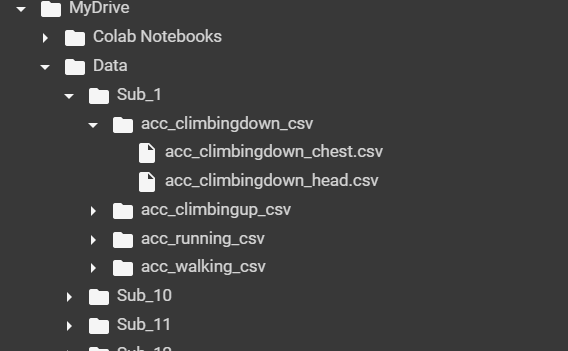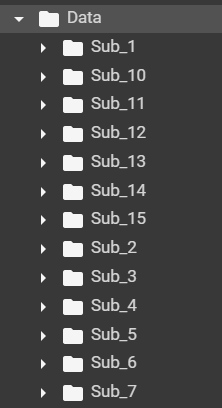




In [ ]:
data_path = '/content/gdrive/MyDrive/Data'

In [ ]:
folder_list = os.listdir(data_path) # list the folders,files in the path 

### Reading files for Signal length 1024

In [ ]:
temp=pd.DataFrame() # Creating a temporary dataframe to read the files
appended_data = []
count = 1
for i in folder_list:                                 # iterating through each of the Subjects
  act_list = os.listdir(data_path+'/'+i)
  for j in act_list:                                  # iterating through the subfolders
    data_list = os.listdir(data_path+'/'+i+'/'+j)
    for k in data_list:                               # iterating through the files 
      #print(i,j,k)
      temp = pd.read_csv(data_path+'/'+i+'/'+j+'/'+k)
      temp = temp.iloc[0:1024,:]
      temp1 = pd.melt(temp, id_vars =['id'], value_vars =['attr_x','attr_y','attr_z'])     #melting the dataframe to have the time series data in horizontal format
      temp2 = temp1.pivot(columns=['id'],values=['value'],index='variable').reset_index()
      temp2.columns = temp2.columns.droplevel(0)
      temp2 = temp2.rename(columns={'':'axis'})
      temp2['Subject'] = i                              # assigning subject name derived from outer folder name 
      temp2['activity'] = j.split('_')[1]               # Using str split to get the activity names
      temp2['sensor_location'] = k.split('_')[2].replace('.csv','') # removing ".csv" from the latter half of the file name to append
      appended_data.append(temp2)                     #append the data to dataframes
df_final_sig_1 = pd.concat(appended_data,ignore_index=True)

### Reading files for Signal length 2048
* The code structure is same as used for signal length 1024

In [ ]:
temp = pd.DataFrame() # Creating a temporary dataframe to read the files
appended_data = []
count = 1
for i in folder_list: # iterating through each of the Subjects
  act_list = os.listdir(data_path+'/'+i)
  for j in act_list:                            # iterating through the subfolders
    data_list = os.listdir(data_path+'/'+i+'/'+j)
    for k in data_list:
     # print(i,j,k)
      temp = pd.read_csv(data_path+'/'+i+'/'+j+'/'+k)
      temp = temp.iloc[:2048,:]                        # subsetting the data for 2048 time series values for each axes
      temp1 = pd.melt(temp, id_vars =['id'], value_vars =['attr_x','attr_y','attr_z'])     #melting the dataframe to have the time series data in horizontal format
      temp2 = temp1.pivot(columns=['id'],values=['value'],index='variable').reset_index()
      temp2.columns = temp2.columns.droplevel(0)
      temp2 = temp2.rename(columns={'':'axis'})
      temp2['Subject'] = i                                            # assigning subject name derived from outer folder name 
      temp2['activity'] = j.split('_')[1]                              # Using str split to get the activity names
      temp2['sensor_location'] = k.split('_')[2].replace('.csv','')
      appended_data.append(temp2)                                    #append the data to dataframes
df_final_sig_2 = pd.concat(appended_data,ignore_index=True)

### Reading files for Signal length 4096

In [ ]:
temp = pd.DataFrame() # Creating a temporary dataframe to read the files
appended_data = []    
count = 1
for i in folder_list:                              # iterating through each of the Subjects
  act_list = os.listdir(data_path+'/'+i)
  for j in act_list:                               # iterating through the subfolders
    data_list = os.listdir(data_path+'/'+i+'/'+j)
    for k in data_list:
      temp = pd.read_csv(data_path+'/'+i+'/'+j+'/'+k)
      temp = temp.iloc[:4096,:]                         # subsetting the data for 4096 time series values for each axes
      temp1 = pd.melt(temp, id_vars =['id'], value_vars =['attr_x','attr_y','attr_z'])
      temp2 = temp1.pivot(columns=['id'],values=['value'],index='variable').reset_index()
      temp2.columns = temp2.columns.droplevel(0)
      temp2 = temp2.rename(columns={'':'axis'})
      temp2['Subject'] = i
      temp2['activity'] = j.split('_')[1]
      temp2['sensor_location'] = k.split('_')[2].replace('.csv','')
      appended_data.append(temp2)
df_final_sig_3 = pd.concat(appended_data,ignore_index=True)

## Creating dataframe from Signal length 1024

#### Parameters to vary Dimension 3,4,5,6 ; Delay 1,2,3
#### Hence 4*3 =12 repetiotions of each row

In [ ]:
df_final_sig_1.shape

(360, 1028)

In [ ]:
#number of rows after repetition should be 
360*12

4320

### Creating repetions to vary the parameters

In [ ]:
df_cal_sig_1 = pd.DataFrame(np.repeat(df_final_sig_1.values, 12, axis=0))
df_cal_sig_1.columns = df_final_sig_1.columns

### Creating empty columns to assign permutation entropy , complexity and dimension,delay values

In [ ]:
df_cal_sig_1['permutation_entropy'] = ''
df_cal_sig_1['complexity'] = ''
df_cal_sig_1['dimension'] = ''
df_cal_sig_1['delay'] = ''
df_cal_sig_1['signal_length'] = '1024'
col_list_sig_1 = list(np.arange(1,1025))
dimensions = ['3','4','5','6']*int((4320/4)) # creating a list with dimension values and repeating them according to number of rows
delay = ['1','2','3']*int(4320/3)           # creating a list of delay and repeating them according to number of rows
df_cal_sig_1['dimension'] = dimensions
df_cal_sig_1['delay'] = delay

In [ ]:
df_cal_sig_1.head()

id,axis,1,2,3,4,5,6,7,8,9,...,1023,1024,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.86388,0.113789,3,1,1024
1,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.93704,0.073841,4,2,1024
2,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.96128,0.0656915,5,3,1024
3,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.847851,0.197632,6,1,1024
4,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.960872,0.0360534,3,2,1024


* Each row of the dataframe has the parameters which are required to be varied and the time series which needs to be used to calculate the signal 

### Iterating over the data frame to generating entropy,complexity values after generating ordinal pattern variables

In [ ]:
for index,row in df_cal_sig_1.iterrows(): # generating row, index using iterrows object and iterating through each using the row object
    ts = row[col_list_sig_1]
    op = ordinal_patterns(ts,int(row['dimension']),int(row['delay'])) # passig the required values from each row to calc ordinal patterns
    p_ent = p_entropy(op)                                             #calculating entropy values for each row
    comp = complexity(op)                                             # calculating complexity values for each row 
    row['permutation_entropy'] = p_ent                                #assigning the calculated values using the "row" object
    row['complexity'] = comp

In [ ]:
df_cal_sig_1.head()

id,axis,1,2,3,4,5,6,7,8,9,...,1023,1024,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.86388,0.113789,3,1,1024
1,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.93704,0.073841,4,2,1024
2,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.96128,0.0656915,5,3,1024
3,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.847851,0.197632,6,1,1024
4,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,17.7362,14.3892,Sub_1,climbingdown,chest,0.960872,0.0360534,3,2,1024


## Creating Data frame for signal length 2048

In [ ]:
df_final_sig_2.shape # original shape of the 

(360, 2052)

In [ ]:
#number of rows after repetition should be 
360*12

4320

In [ ]:
df_cal_sig_2 = pd.DataFrame(np.repeat(df_final_sig_2.values, 12, axis=0))   # repeating the number of rows 
df_cal_sig_2.columns = df_final_sig_2.columns

In [ ]:
# creating empty columns  
df_cal_sig_2['permutation_entropy'] = ''
df_cal_sig_2['complexity'] = ''
df_cal_sig_2['dimension'] = ''
df_cal_sig_2['delay'] = ''
df_cal_sig_2['signal_length'] = '2048'
col_list_sig_2 = list(np.arange(1,2049))
dimensions = ['3','4','5','6']*int((4320/4))    # generating delay and dimension values
delay = ['1','2','3']*int(4320/3)
df_cal_sig_2['dimension'] = dimensions          # assigning the values
df_cal_sig_2['delay'] = delay

In [ ]:
for index,row in df_cal_sig_2.iterrows():                            # iterating over each row using iterrows
    ts = row[col_list_sig_2]
    op = ordinal_patterns(ts,int(row['dimension']),int(row['delay']))  # generating ordinal patterns 
    p_ent = p_entropy(op)
    comp = complexity(op)
    row['permutation_entropy'] = p_ent                                 
    row['complexity'] = comp

In [ ]:
df_cal_sig_2.shape

(4320, 2057)

In [ ]:
df_cal_sig_2.head()

id,axis,1,2,3,4,5,6,7,8,9,...,2047,2048,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,7.87632,7.78295,Sub_1,climbingdown,chest,0.815191,0.147157,3,1,2048
1,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,7.87632,7.78295,Sub_1,climbingdown,chest,0.898196,0.114007,4,2,2048
2,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,7.87632,7.78295,Sub_1,climbingdown,chest,0.940886,0.0968823,5,3,2048
3,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,7.87632,7.78295,Sub_1,climbingdown,chest,0.769591,0.265514,6,1,2048
4,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,7.87632,7.78295,Sub_1,climbingdown,chest,0.932532,0.0604123,3,2,2048


## Creating Dataframe or signal length 4096

In [ ]:
df_final_sig_3.head()

id,axis,1,2,3,4,5,6,7,8,9,...,4090,4091,4092,4093,4094,4095,4096,Subject,activity,sensor_location
0,attr_x,5.616797,5.589264,5.580884,5.588067,5.583877,5.596446,5.609016,5.600637,5.589264,...,9.104550,12.896367,15.990873,15.150508,12.567164,11.906365,14.710574,Sub_1,climbingdown,chest
1,attr_y,8.064270,8.054693,8.060080,8.033744,8.060678,8.047510,8.051102,8.058883,8.024167,...,1.574188,2.871246,4.510078,5.397728,6.025009,5.814918,7.933786,Sub_1,climbingdown,chest
2,attr_z,0.878073,0.869095,0.908001,0.884658,0.875679,0.858920,0.862511,0.869694,0.891242,...,1.038485,0.195726,-1.483807,-2.383428,-0.504578,3.147777,3.676297,Sub_1,climbingdown,chest
3,attr_x,-4.325125,-4.313154,-4.326921,-4.317344,-4.347870,-4.347870,-4.297592,-4.273650,-4.267664,...,3.220201,2.862268,2.439691,2.117672,2.461838,2.959233,2.864064,Sub_1,climbingdown,head
4,attr_y,8.662820,8.675988,8.726865,8.771756,8.815451,8.743625,8.713697,8.686164,8.658031,...,8.963891,7.330447,6.024410,5.545570,6.955156,7.910442,7.667431,Sub_1,climbingdown,head


In [ ]:
df_final_sig_3.shape

(360, 4100)

In [ ]:
#number of rows after repetition should be 
360*4

1440

In [ ]:
df_cal_sig_3 = pd.DataFrame(np.repeat(df_final_sig_3.values, 12, axis=0))
df_cal_sig_3.columns = df_final_sig_3.columns

In [ ]:
df_cal_sig_3.shape

(4320, 4100)

#### Creating empty values and assigning dimensions and delay values

In [ ]:
df_cal_sig_3['permutation_entropy'] = ''
df_cal_sig_3['complexity'] = ''
df_cal_sig_3['dimension'] = ''
df_cal_sig_3['delay'] = ''
df_cal_sig_3['signal_length'] = '4096'
col_list_sig_3 = list(np.arange(1,4097))
dimensions = ['3','4','5','6']*int((4320/4))
delay = ['1','2','3']*int(4320/3)
df_cal_sig_3['dimension'] = dimensions
df_cal_sig_3['delay'] = delay

In [ ]:
for index,row in df_cal_sig_3.iterrows():  # iterating over the dataframe
    ts = row[col_list_sig_3] # passing the ts of length 4096
    op = ordinal_patterns(ts,int(row['dimension']),int(row['delay'])) # passing the values to generate ordinal patterns using dimension,delay
    p_ent = p_entropy(op)  # calculating entropy 
    comp = complexity(op) # calculating complexity
    row['permutation_entropy'] = p_ent # assigning the value to each row
    row['complexity'] = comp           # assigning the complexity value to each row 

In [ ]:
df_cal_sig_3.shape

(4320, 4105)

In [ ]:
df_cal_sig_3.head()

id,axis,1,2,3,4,5,6,7,8,9,...,4095,4096,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,11.9064,14.7106,Sub_1,climbingdown,chest,0.797726,0.158015,3,1,4096
1,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,11.9064,14.7106,Sub_1,climbingdown,chest,0.88701,0.128886,4,2,4096
2,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,11.9064,14.7106,Sub_1,climbingdown,chest,0.944521,0.0921359,5,3,4096
3,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,11.9064,14.7106,Sub_1,climbingdown,chest,0.735716,0.304858,6,1,4096
4,attr_x,5.6168,5.58926,5.58088,5.58807,5.58388,5.59645,5.60902,5.60064,5.58926,...,11.9064,14.7106,Sub_1,climbingdown,chest,0.927089,0.064861,3,2,4096


### dropping all the timeseries columns appending the dataframe to create output table 

In [ ]:
df_plot_sig_1 = df_cal_sig_1.drop(col_list_sig_1,axis=1) # dropping the time series values for 1024 length ts
df_plot_sig_2 = df_cal_sig_2.drop(col_list_sig_2,axis=1) # dropping the time series values for 2048 length ts
df_plot_sig_3 = df_cal_sig_3.drop(col_list_sig_3,axis=1) # dropping the time series values for 4096 length ts

In [ ]:
df_plot_sig_1.shape # checking the shape of each dataframe

(4320, 9)

In [ ]:
df_plot_sig_2.shape # checking the shape of dataframe

(4320, 9)

In [ ]:
df_plot_sig_3.shape

(4320, 9)

In [ ]:
df_plot_sig_1.head()

id,axis,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,Sub_1,climbingdown,chest,0.86388,0.113789,3,1,1024
1,attr_x,Sub_1,climbingdown,chest,0.93704,0.073841,4,2,1024
2,attr_x,Sub_1,climbingdown,chest,0.96128,0.0656915,5,3,1024
3,attr_x,Sub_1,climbingdown,chest,0.847851,0.197632,6,1,1024
4,attr_x,Sub_1,climbingdown,chest,0.960872,0.0360534,3,2,1024


In [ ]:
df_plot_sig_2.head()

id,axis,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,Sub_1,climbingdown,chest,0.815191,0.147157,3,1,2048
1,attr_x,Sub_1,climbingdown,chest,0.898196,0.114007,4,2,2048
2,attr_x,Sub_1,climbingdown,chest,0.940886,0.0968823,5,3,2048
3,attr_x,Sub_1,climbingdown,chest,0.769591,0.265514,6,1,2048
4,attr_x,Sub_1,climbingdown,chest,0.932532,0.0604123,3,2,2048


In [ ]:
df_plot_sig_3.head()

id,axis,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,Sub_1,climbingdown,chest,0.797726,0.158015,3,1,4096
1,attr_x,Sub_1,climbingdown,chest,0.88701,0.128886,4,2,4096
2,attr_x,Sub_1,climbingdown,chest,0.944521,0.0921359,5,3,4096
3,attr_x,Sub_1,climbingdown,chest,0.735716,0.304858,6,1,4096
4,attr_x,Sub_1,climbingdown,chest,0.927089,0.064861,3,2,4096


In [ ]:
df_plot = pd.concat([df_plot_sig_1,df_plot_sig_2,df_plot_sig_3],ignore_index=True) # Concatinating all the dataframes to form the output table

### Scatter Plots for Walking and Running 

#### Plots for Signal Length 4096 ,delay=1

In [ ]:
df_plot.head()

id,axis,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
0,attr_x,Sub_1,climbingdown,chest,0.86388,0.113789,3,1,1024
1,attr_x,Sub_1,climbingdown,chest,0.93704,0.073841,4,2,1024
2,attr_x,Sub_1,climbingdown,chest,0.96128,0.0656915,5,3,1024
3,attr_x,Sub_1,climbingdown,chest,0.847851,0.197632,6,1,1024
4,attr_x,Sub_1,climbingdown,chest,0.960872,0.0360534,3,2,1024


In [ ]:
df_plot.shape

(12960, 9)

#### Subsetting the dataframe for walking and running activities , signal length = 4096 and delay=1

In [ ]:
df_plot_wr_sig_3 = df_plot[(df_plot['activity'].isin(['walking','running'])) & (df_plot['signal_length']=='4096') & (df_plot['delay']=='1')]

In [ ]:
df_plot_wr_sig_3.head()

id,axis,Subject,activity,sensor_location,permutation_entropy,complexity,dimension,delay,signal_length
8784,attr_x,Sub_1,running,chest,0.896041,0.0898345,3,1,4096
8787,attr_x,Sub_1,running,chest,0.862551,0.225492,6,1,4096
8790,attr_x,Sub_1,running,chest,0.831496,0.228029,5,1,4096
8793,attr_x,Sub_1,running,chest,0.84763,0.165825,4,1,4096
8796,attr_y,Sub_1,running,chest,0.678836,0.20454,3,1,4096


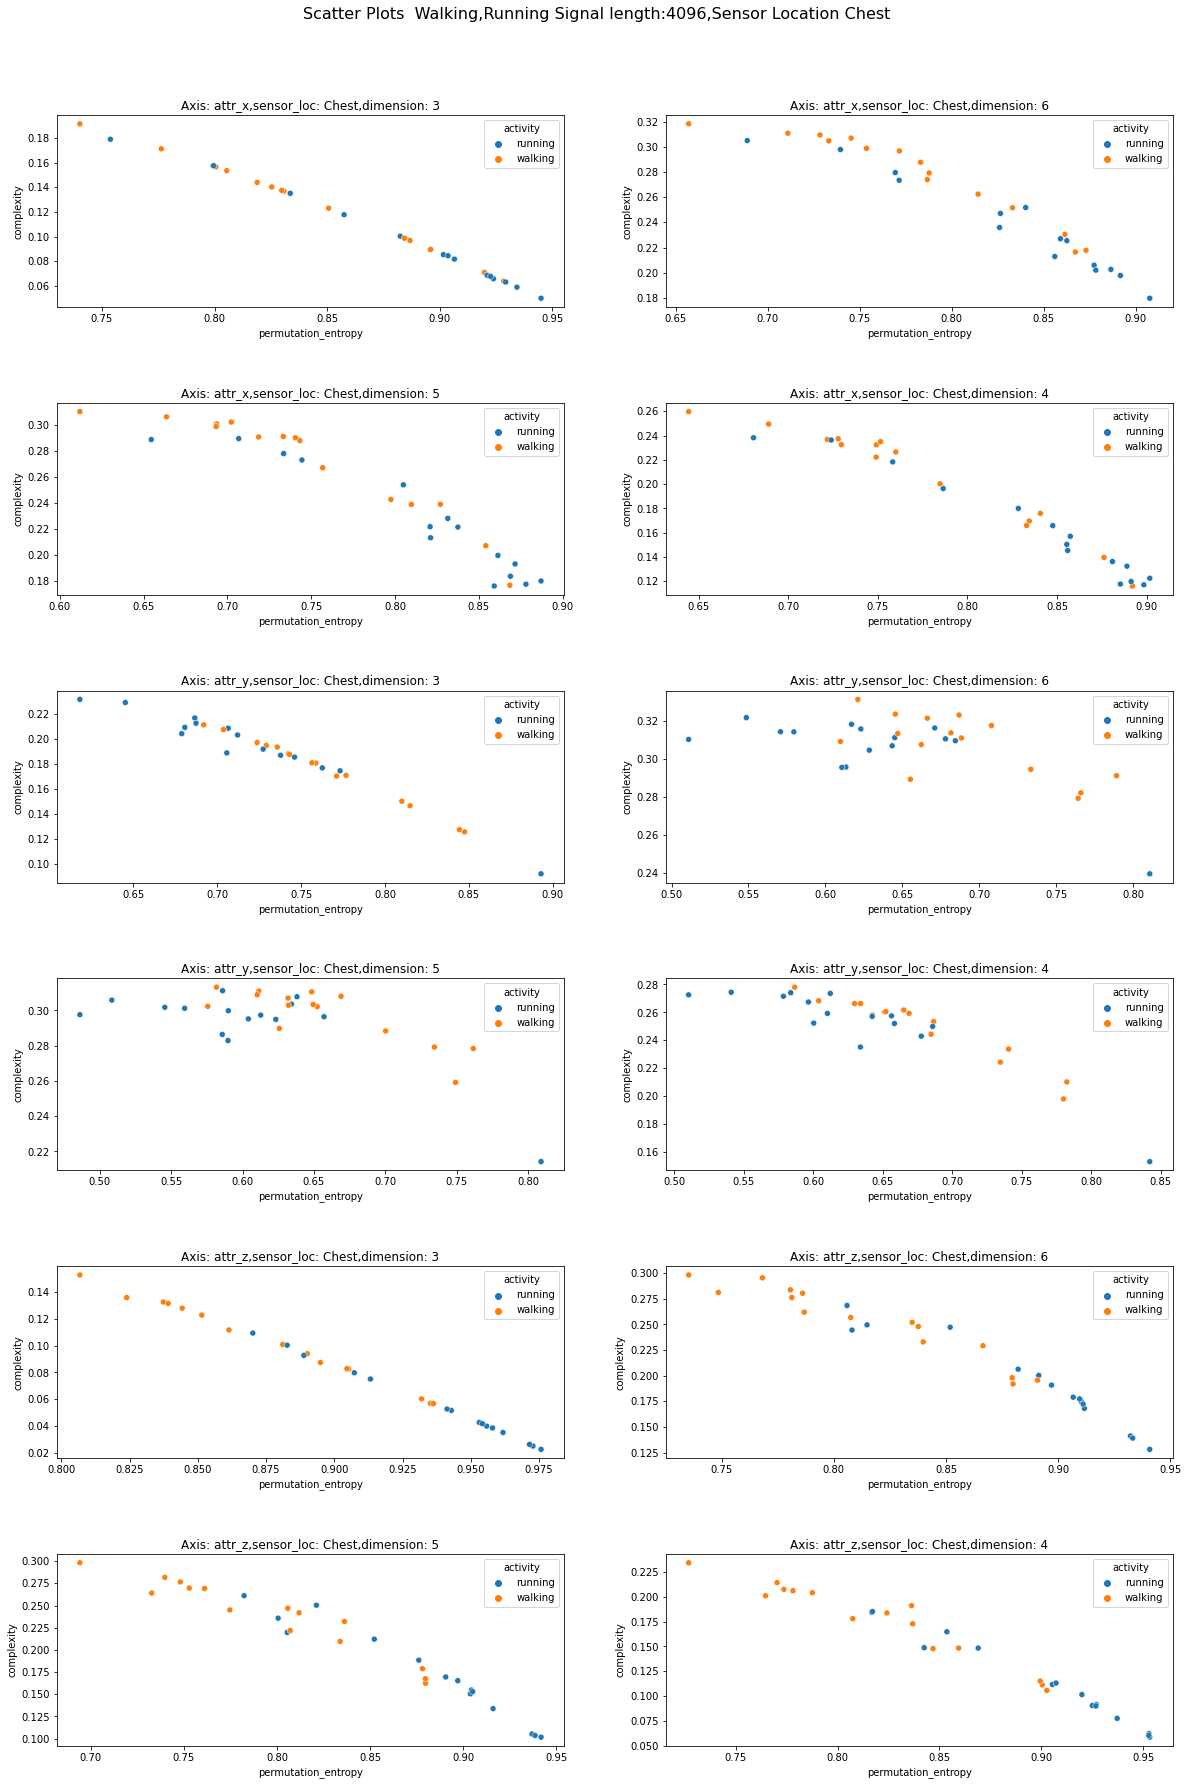

In [ ]:
plt.figure(figsize=(20,30))             # setting the figure size 
plt.subplots_adjust(hspace=0.5)         #
plt.suptitle("Scatter Plots  Walking,Running Signal length:4096,Sensor Location Chest", fontsize=16, y=0.93)
count=1
for i in df_plot_wr_sig_3['axis'].unique():          # iterating through unique values in axis
    for k in df_plot_wr_sig_3['dimension'].unique(): # iterating through the dimesnion 3,4,5,6 
        # Subsetting the data iterating over different axes and dimesnions(chest)
        temp=df_plot_wr_sig_3[(df_plot_wr_sig_3['axis']==i) & (df_plot_wr_sig_3['sensor_location']=='chest') & (df_plot_wr_sig_3['dimension']==k) ]
        ax = plt.subplot(6, 2, count )    
        sns.scatterplot('permutation_entropy','complexity',data=temp,hue='activity') #plotting the scatterplot for the subsetted data    
        ax.set_title(str('Axis: '+  i+',sensor_loc: '+'Chest'+',dimension: '+k))
        if count<12:
            count=count+1

#### Plotting the scatter plots for sensor location chest ,Activity : Walking,Running, Signal :4096

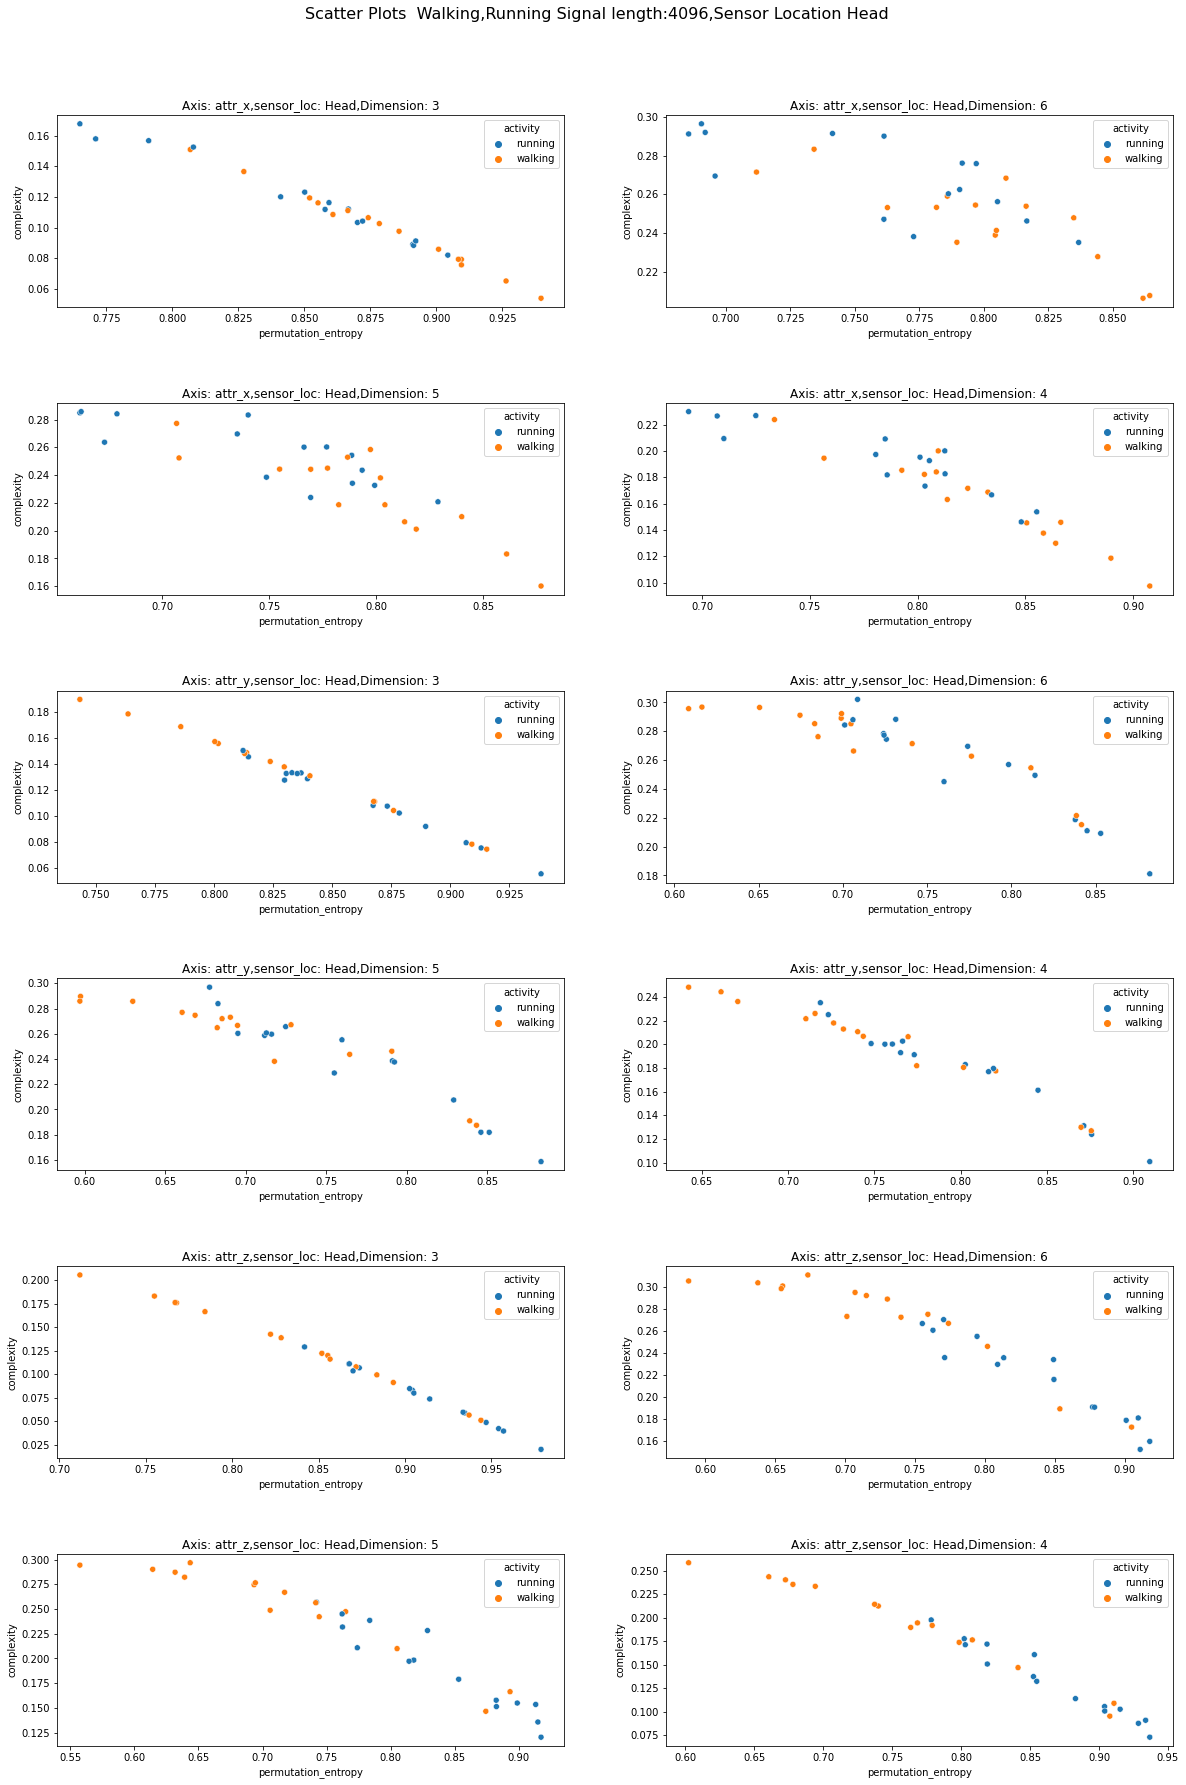

In [ ]:
# Code Structure is same as above 
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Scatter Plots  Walking,Running Signal length:4096,Sensor Location Head", fontsize=16, y=0.93)
count=1
for i in df_plot_wr_sig_3['axis'].unique():           # iterating through unique values in axis
    for k in df_plot_wr_sig_3['dimension'].unique():  # iterating through the dimesnion 3,4,5,6 
        # SUbsetting sensor location for head and iterating over other columns 
        temp=df_plot_wr_sig_3[(df_plot_wr_sig_3['axis']==i) & (df_plot_wr_sig_3['sensor_location']=='head') & (df_plot_wr_sig_3['dimension']==k) ]
        ax = plt.subplot(6, 2, count )    
        sns.scatterplot('permutation_entropy','complexity',data=temp,hue='activity')    
        ax.set_title(str('Axis: '+  i+',sensor_loc: '+'Head'+',Dimension: '+k)) # setting the title 
        if count<12:
            count=count+1

#### Subsetting the data for activity climbing up , climbingdown , signal length 4096, delay 1

In [ ]:
df_plot_wr_sig_4 = df_plot[(df_plot['activity'].isin(['climbingup','climbingdown'])) & (df_plot['signal_length']=='4096') & (df_plot['delay']=='1')]

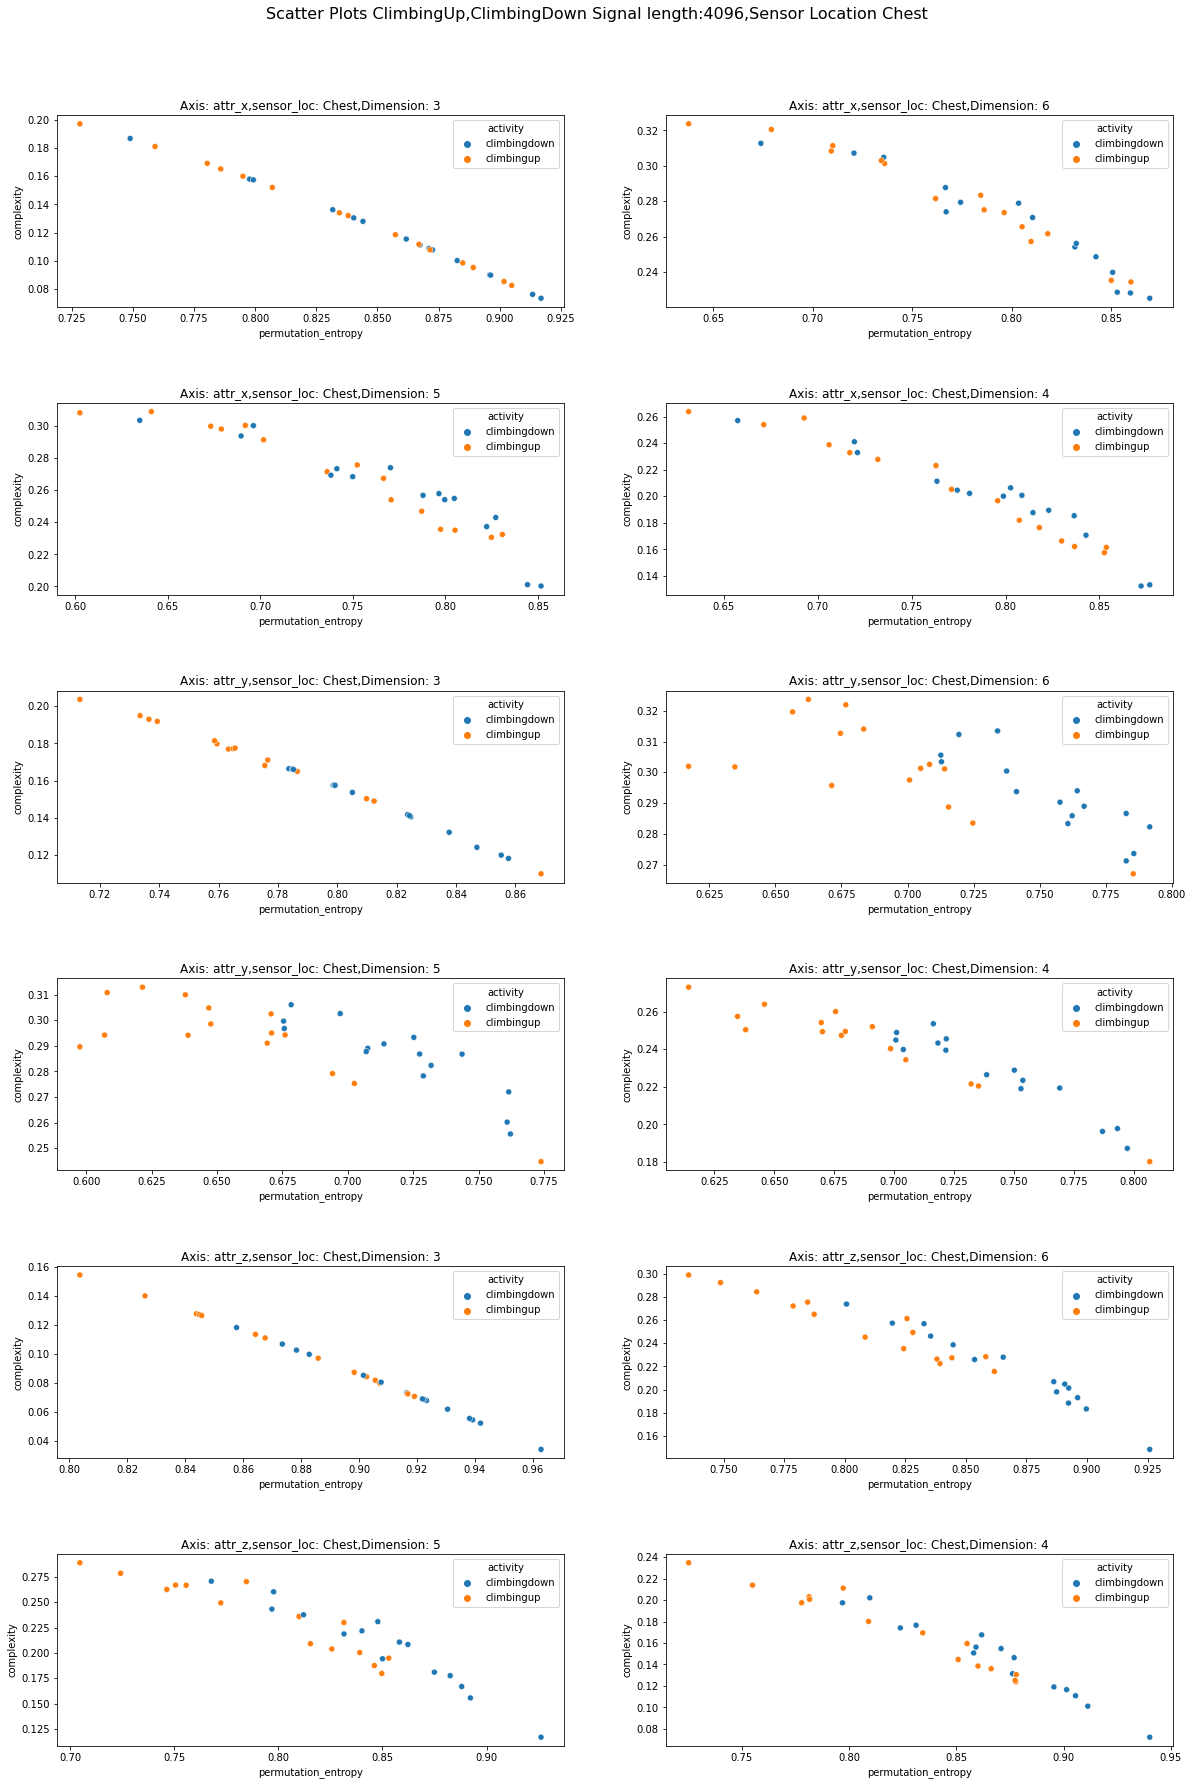

In [ ]:
# code structure is same as above
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Scatter Plots ClimbingUp,ClimbingDown Signal length:4096,Sensor Location Chest", fontsize=16, y=0.93)
count=1
for i in df_plot_wr_sig_4['axis'].unique():
    for k in df_plot_wr_sig_4['dimension'].unique():
        #Subsetting vales for sensor location as chest
        temp=df_plot_wr_sig_4[(df_plot_wr_sig_4['axis']==i) & (df_plot_wr_sig_4['sensor_location']=='chest') & (df_plot_wr_sig_4['dimension']==k) ]
        ax = plt.subplot(6, 2, count )    
        sns.scatterplot('permutation_entropy','complexity',data=temp,hue='activity')    
        ax.set_title(str('Axis: '+  i+',sensor_loc: '+'Chest'+',Dimension: '+k))
        if count<12:
            count=count+1

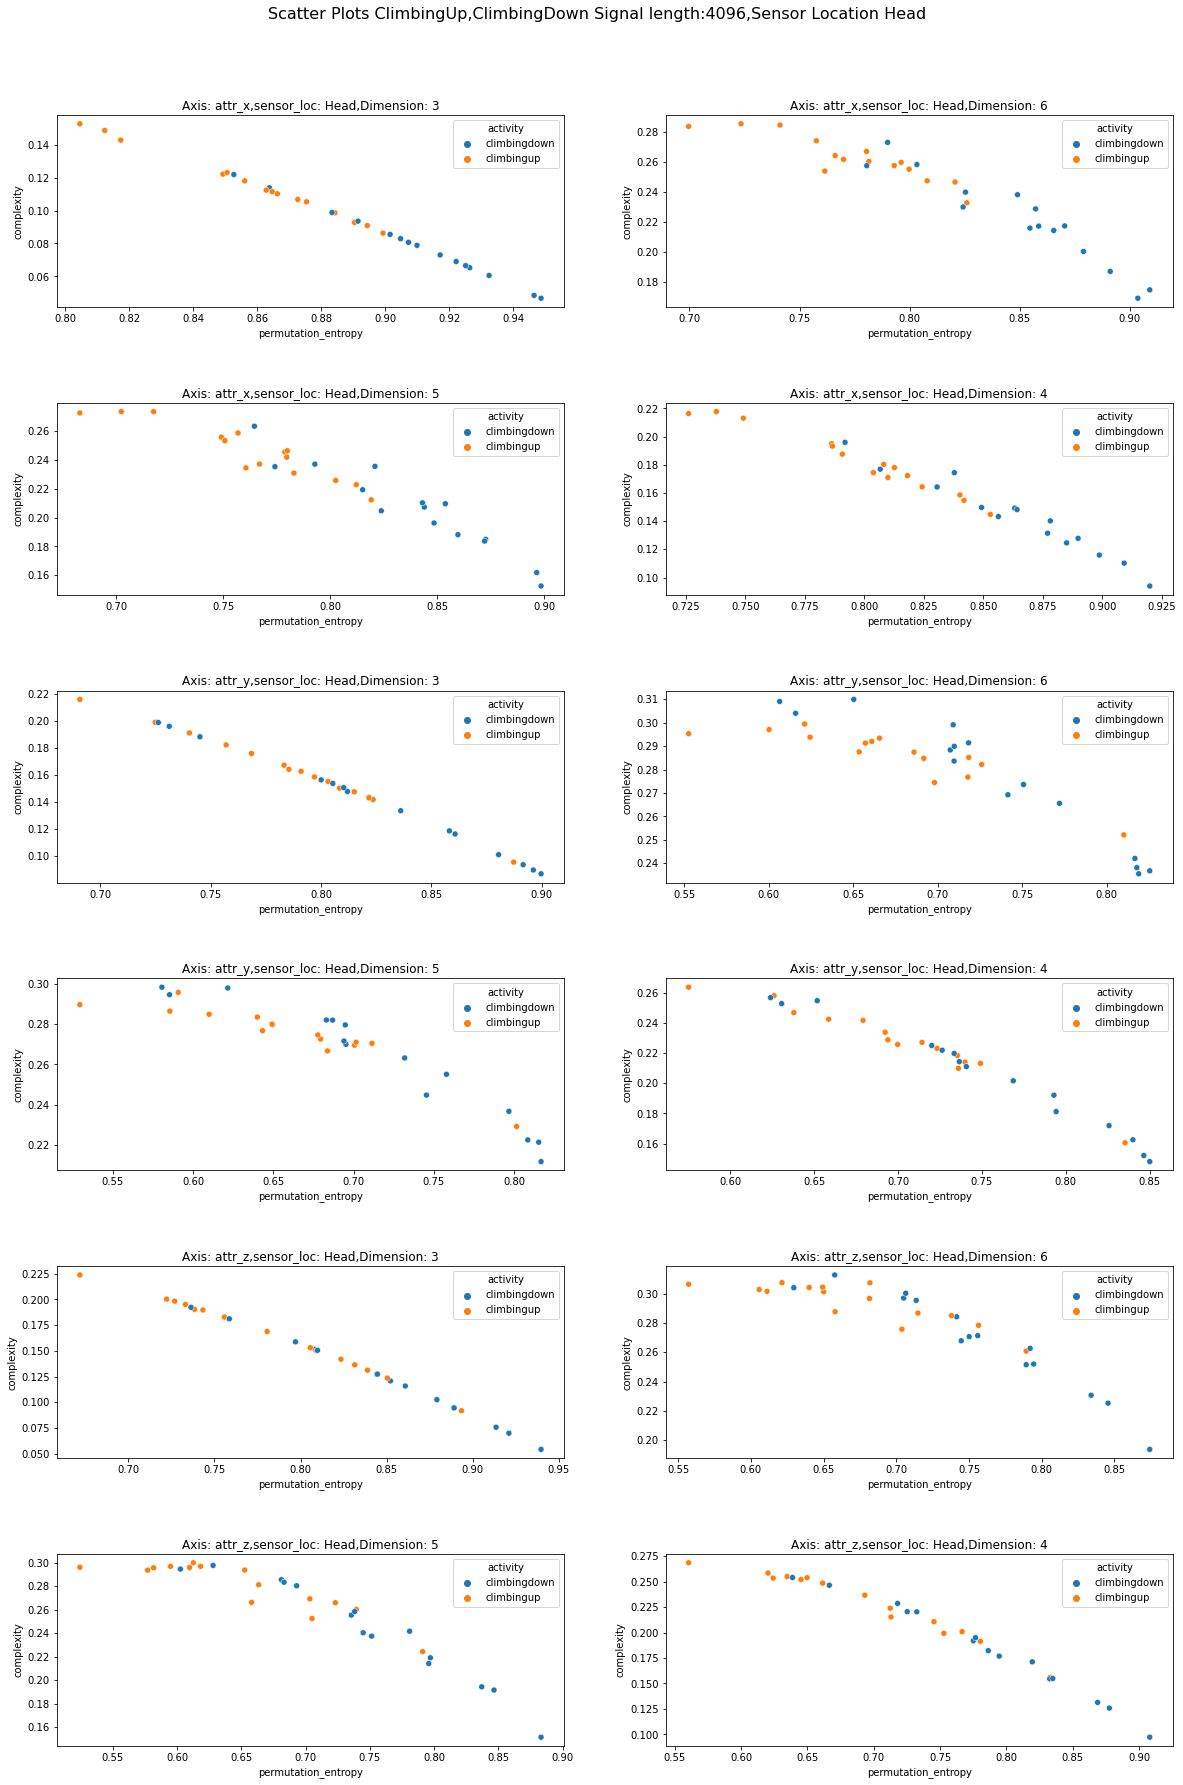

In [ ]:
#code structure is same as above
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Scatter Plots ClimbingUp,ClimbingDown Signal length:4096,Sensor Location Head", fontsize=16, y=0.93)
count=1
for i in df_plot_wr_sig_4['axis'].unique():
    for k in df_plot_wr_sig_4['dimension'].unique(): 
        # setting sensor location for head 
        temp=df_plot_wr_sig_4[(df_plot_wr_sig_4['axis']==i) & (df_plot_wr_sig_4['sensor_location']=='head') & (df_plot_wr_sig_4['dimension']==k) ]
        ax = plt.subplot(6, 2, count )    
        sns.scatterplot('permutation_entropy','complexity',data=temp,hue='activity')    
        ax.set_title(str('Axis: '+  i+',sensor_loc: '+'Head'+',Dimension: '+k))
        if count<12:
            count=count+1

In [1]:
!jupyter nbconvert -- to html Group_53_Project_2_Task_2

[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'html' matched no files
[NbConvertApp] Converting notebook Group_53_Project_2_Task_2.ipynb to html
[NbConvertApp] Writing 1279247 bytes to Group_53_Project_2_Task_2.html
